In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Definir las constantes
g = 9.8 # gravedad [m/s^2]
p_atm = 101325 # Presión atmosférica [Pa]
beta = 3.67e-3 # Coeficiente de expansion termica [1/K]
T_w = 80.0 + 273.0 # Temperatura de la pared [K]
T_a = 20.0 + 273.0 # Temperatura ambiente [K]
delta_T = T_w - T_a
lambda_f = 0.04 # Coeficiente de friccion [adimensional]
R = 10.0 # Radio de la tuberia [m]
L = 100.0 # Longitud de la tuberia [m]
alpha = 2.2e-5 # Coeficiente de difusividad [m^2/s]
rho_0 = 1.0 # Densidad [kg/m^3]
Cp = 1.012 # Capacidad calorifica [J/(kg K)]
k = 0.024 # Conductividad termica [W/(m K)]
nu = 1.71e-5 # Viscosidad [Pa s]
Ra_D = (g * beta * delta_T * (2 * R)**3)/ nu**2 # Numero de Rayleigh
Nu = (576/(Ra_D * 2 * R /L)**2 + 2.873/(Ra_D * 2 * R /L)**(1/2))**(-1/2)# Numero de Nusselt
h_v = (k * Nu)/ (2 * R * L) # coeficiente de tranferencia de calor por convección [W/(m^3 K)]

## Solución estacionaria, calculo de $u_e$

In [10]:
def f(u, A, B):
    return u - A * (1 - np.exp(-B/u))

def df(u, A, B):
    return 1 + A * (B/u**2) * np.exp(-B/u)

def newton_raphson(A, B, u0, tol, max_iter):
    u = u0
    for i in range(max_iter):
        f_val = f(u, A, B)
        df_val = df(u, A, B)
        u_new = u - f_val / df_val
        if np.abs(u_new - u) < tol:
            return u_new
        u = u_new
    return u

A = rho_0 * Cp * g * beta * (T_w - T_a) / (h_v * (0.5 + lambda_f * L /(8 * R)))
B = h_v * L / (rho_0 * Cp)
u0 = 0.01
tol = 1e-6
max_iter = 100

u_sol = newton_raphson(A, B, u0, tol, max_iter)
u_e = u_sol
print('u_e = ' + str(round(u_e,4))+ ' m/s')

gamma = h_v * L / (rho_0 * Cp * u_e)
T_f = T_a + (T_w - T_a) * (1 - np.exp(-gamma))
print('T_f = ' + str(T_f))

u_e = 19.4829 m/s
T_f = 296.86366876093643


## Adimensionalización

In [11]:
gamma = h_v * L / (rho_0 * Cp * u_e)
T_f = T_a + (T_w - T_a) * (1 - np.exp(-gamma))

Pi_d = rho_0 * u_e**2 / p_atm
Pi_0 = rho_0 * g * L / p_atm
phi = L * g * beta * (T_f - T_a) / u_e**2
theta_r = (T_w -T_a) / (T_f - T_a)
LAMBDA = lambda_f * L / (8 * R)
delta = alpha /(u_e * L)

print('Pi_0 = ' + str(Pi_0))
print('Pi_d = ' + str(Pi_d))
print('delta = ' + str(delta))
print('gamma = ' + str(gamma))
print('LAMBDA = ' + str(LAMBDA))
print('theta_r = ' + str(theta_r))
print('phi = ' + str(phi))

Pi_0 = 0.009671848013816927
Pi_d = 0.0037461972810798536
delta = 1.129195275611716e-08
gamma = 0.06656134363640165
LAMBDA = 0.05
theta_r = 15.529281548829731
phi = 0.036608739000020846


## Simulación numérica
1) Bernoulli en $\eta = 0$
2) Energia para sacar $\theta$
3) Cant. movi. para la distribución de presiones

/var/folders/lx/vhxvbgp94fj63r8wrldf_13m0000gn/T/ipykernel_2311/1359479090.py:20: RuntimeWarning: invalid value encountered in sqrt
  v[t] = np.sqrt(2 * (Pi[0, t-1] - 1) / Pi_d)


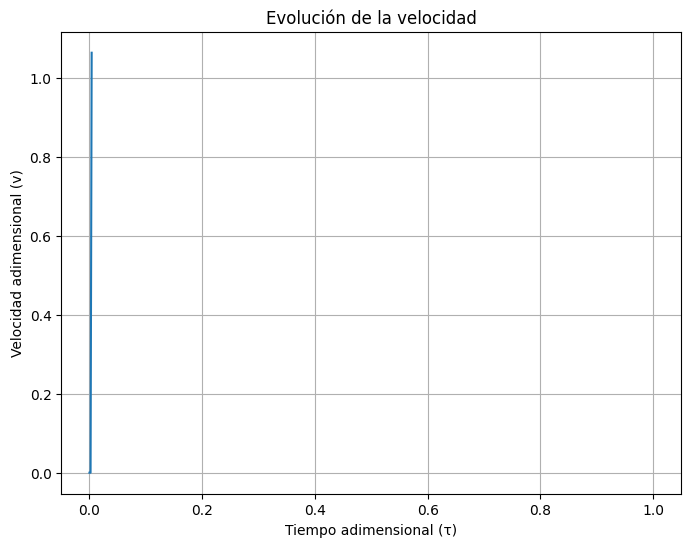

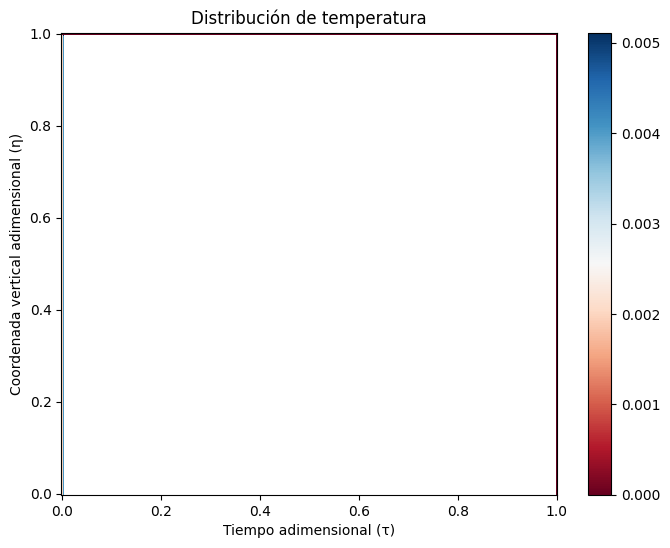

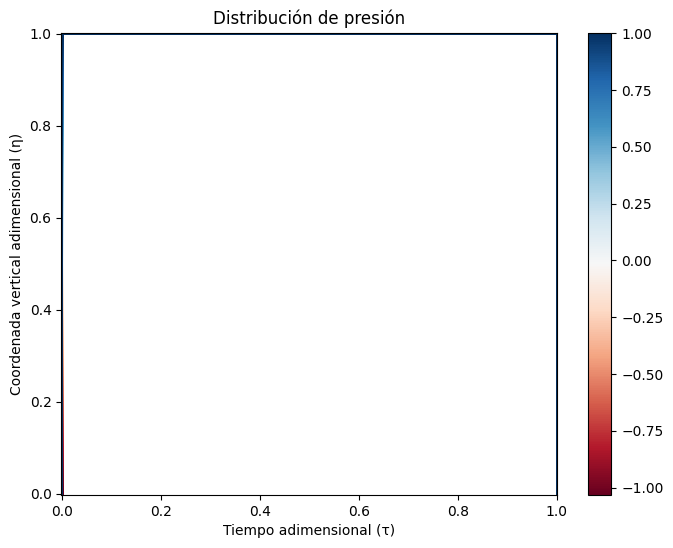

In [12]:
# Definición de variables y condiciones iniciales
M = 256 # Número de puntos en la dirección vertical
N = 512 # Número de puntos en la dirección temporal
eta = np.linspace(0, 1, M)  # Coordenada vertical adimensional
tau = np.linspace(0, 1, N)  # Coordenada temporal adimensional
deta = (eta[-1] - eta[0])/M
dtau = (tau[-1] - tau[0])/N 
v = np.zeros(N)  # Velocidad adimensional
theta = np.zeros((M, N))  # Temperatura adimensional
Pi = np.ones((M, N))  # Presión adimensional, inicialmente todo el espacio se encuentra a p_atm

# Condiciones iniciales
v[0] = 0.0  # Velocidad inicial cero
theta[:, 0] = 0.0  # Temperatura inicial uniforme

# Simulación numérica
for t in range(1, N-1):

    # Calculo de la velocidad en el instante i+1 a partir de la presión en eta = 0 del instante anterior:
    v[t] = np.sqrt(2 * (Pi[0, t-1] - 1) * Pi_d)

    # Calculo de las distribuciones de temperatura y presion en el espacio para el instante i+1:
    for x in range(M-1):
         
        dtheta_deta = (theta[x+1, t-1] - theta[x, t-1]) / deta
        d2theta_deta2 = (theta[x+1, t-1] - 2 * theta[x, t-1] + theta[x-1, t-1]) / deta**2
        theta[x, t] = theta[x, t-1] + dtau * (- v[t] * dtheta_deta
                                            + delta * d2theta_deta2
                                            - gamma * (theta[x, t-1] - theta_r))
        
        dv_dt = (v[t] - v[t-1]) / dtau
        Pi[M-2-x, t] = Pi[M-1-x, t-1] - deta * Pi_d * (dv_dt + phi * (theta[M-2-x, t] - theta_r) + LAMBDA * v[t]**2)  

# Gráfico lineal de v
plt.figure(figsize=(8, 6))
plt.plot(tau, v)
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Velocidad adimensional (v)')
plt.title('Evolución de la velocidad')
plt.grid()
plt.show()

# Mapa de calor de θ
plt.figure(figsize=(8, 6))
plt.pcolormesh(tau, eta, theta, cmap='RdBu')
plt.colorbar()
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Coordenada vertical adimensional (η)')
plt.title('Distribución de temperatura')
plt.show()

# Mapa de calor de Π
plt.figure(figsize=(8, 6))
plt.pcolormesh(tau, eta, Pi, cmap='RdBu')
plt.colorbar()
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Coordenada vertical adimensional (η)')
plt.title('Distribución de presión')
plt.show()


## Notas

En la ecuación de Bernoulli, he modificado el signo del término cinético porque no le veía mucho sentido a que la presión dentro de la chimenea fuera menor que la de fuera si en ella esta actuando una fuerza debida a la velocidad mas la de gravitación, y que además van en sentidos contrarios. Por tanto cambié la ecuación:

$\Pi +\frac{1}{2} \Pi_d v^2 + \Pi_0 \eta \Rightarrow \Pi - \frac{1}{2} \Pi_d v^2 + \Pi_0 \eta$

Con este cambio se asegura que en la raiz del calculo de la velocidad siempre aparezca un valor positivo, solucionando uno de los problemas que tenía obteniendo velocidades negativas o con valores imaginarios.

En este caso, la velocidad y la temperatura sobretodo tienen muy buena pinta porque la velocidad comienza aumentando mas bruscamente y luego se va estabilizando. Sin embargo, parece que se trunca a partir de cierto punto, supongoq que debe de ser porque el tiempo caracteristico que hemos cogido no es el adecuado. La temperatura va aumentando hasta alcanzar $T_f$. Lo que no me cuadra es que la temperatura se mantiene constante a lo largo de $\eta$, solo varía en el tiempo.

Por su parte la presión me gustaría más si describiera una evolución radial con centro en el punto (0, 1), pero bueno se le parece bastante y cumple con las condiciones de contorno.